# Instant Payments Readiness & Impact Simulator (DE Banking)

This notebook is a **final analytical summary** of the project.  
It combines:

- **Real Bundesbank data (2022–2024)** — to understand how the German payments market is shifting:
  - from paper-based transfers to electronic SCT / SCT Inst,
  - and how overall domestic volumes increase the infrastructure load.

- **Synthetic instant payment simulations** — to test operational choices:
  - Verification of Payee (VoP) strictness,
  - Fraud filter thresholds.

Together, they answer four hypotheses about **digital adoption, system load, fraud risk and operational workload**.

## Hypotheses Overview

We group the project into four main hypotheses:

1. **H1 — SCT Inst Growth vs Paper-Based Credit Transfers (Real data)**  
   > Are instant transfers really eating paper-based credit transfers?

2. **H2 — Domestic Electronic Payments & System Load (Real data)**  
   > Does total domestic electronic volume keep growing, increasing infrastructure pressure?

3. **H3 — Fraud Threshold vs Manual Review Load (Simulation)**  
   > If we make fraud filters stricter, how much does the manual review workload grow?

4. **H4 — Fraud Threshold vs Risk Exposure (Simulation)**  
   > If we relax fraud filters, how quickly does financial risk (missed fraud) grow?

Additionally, we build a **combined heatmap** (VoP × Fraud) to find an **operating sweet spot**.


In [11]:
# AI Assistance Disclosure
# Some paragraphs in this report (hypothesis descriptions, interpretations, and final summary)  
# were drafted with ChatGPT assistance. 

# Import helper from IPython to show images inside notebook
from IPython.display import Image, display

# Import os to build file paths
import os

# Base folder where all figures are stored
base_fig_path = "../reports/figures"

def show_fig(filename: str, width: int = 700):
    """
    Simple helper to display a saved PNG figure.

    Args:
        filename: file name inside reports/figures/
        width: image width in pixels (for nicer scaling)
    """
    full_path = os.path.join(base_fig_path, filename)
    display(Image(filename=full_path, width=width))


## H1 — SCT Inst vs Paper-Based Credit Transfers (Real Data)

**Question:**  
Does the growth of SCT Instant correlate with the decline of paper-based credit transfers?

**Data:**  
Bundesbank Payments Statistics — Table 3 (Number of transactions, 2022–2024, half-year).

We focus on:

- `Initiated via SEPA credit transfer instant scheme` (SCT Inst)
- `Initiated in paper-based form` (traditional paper mandates)

We aggregate both by half-year and compare them over time.


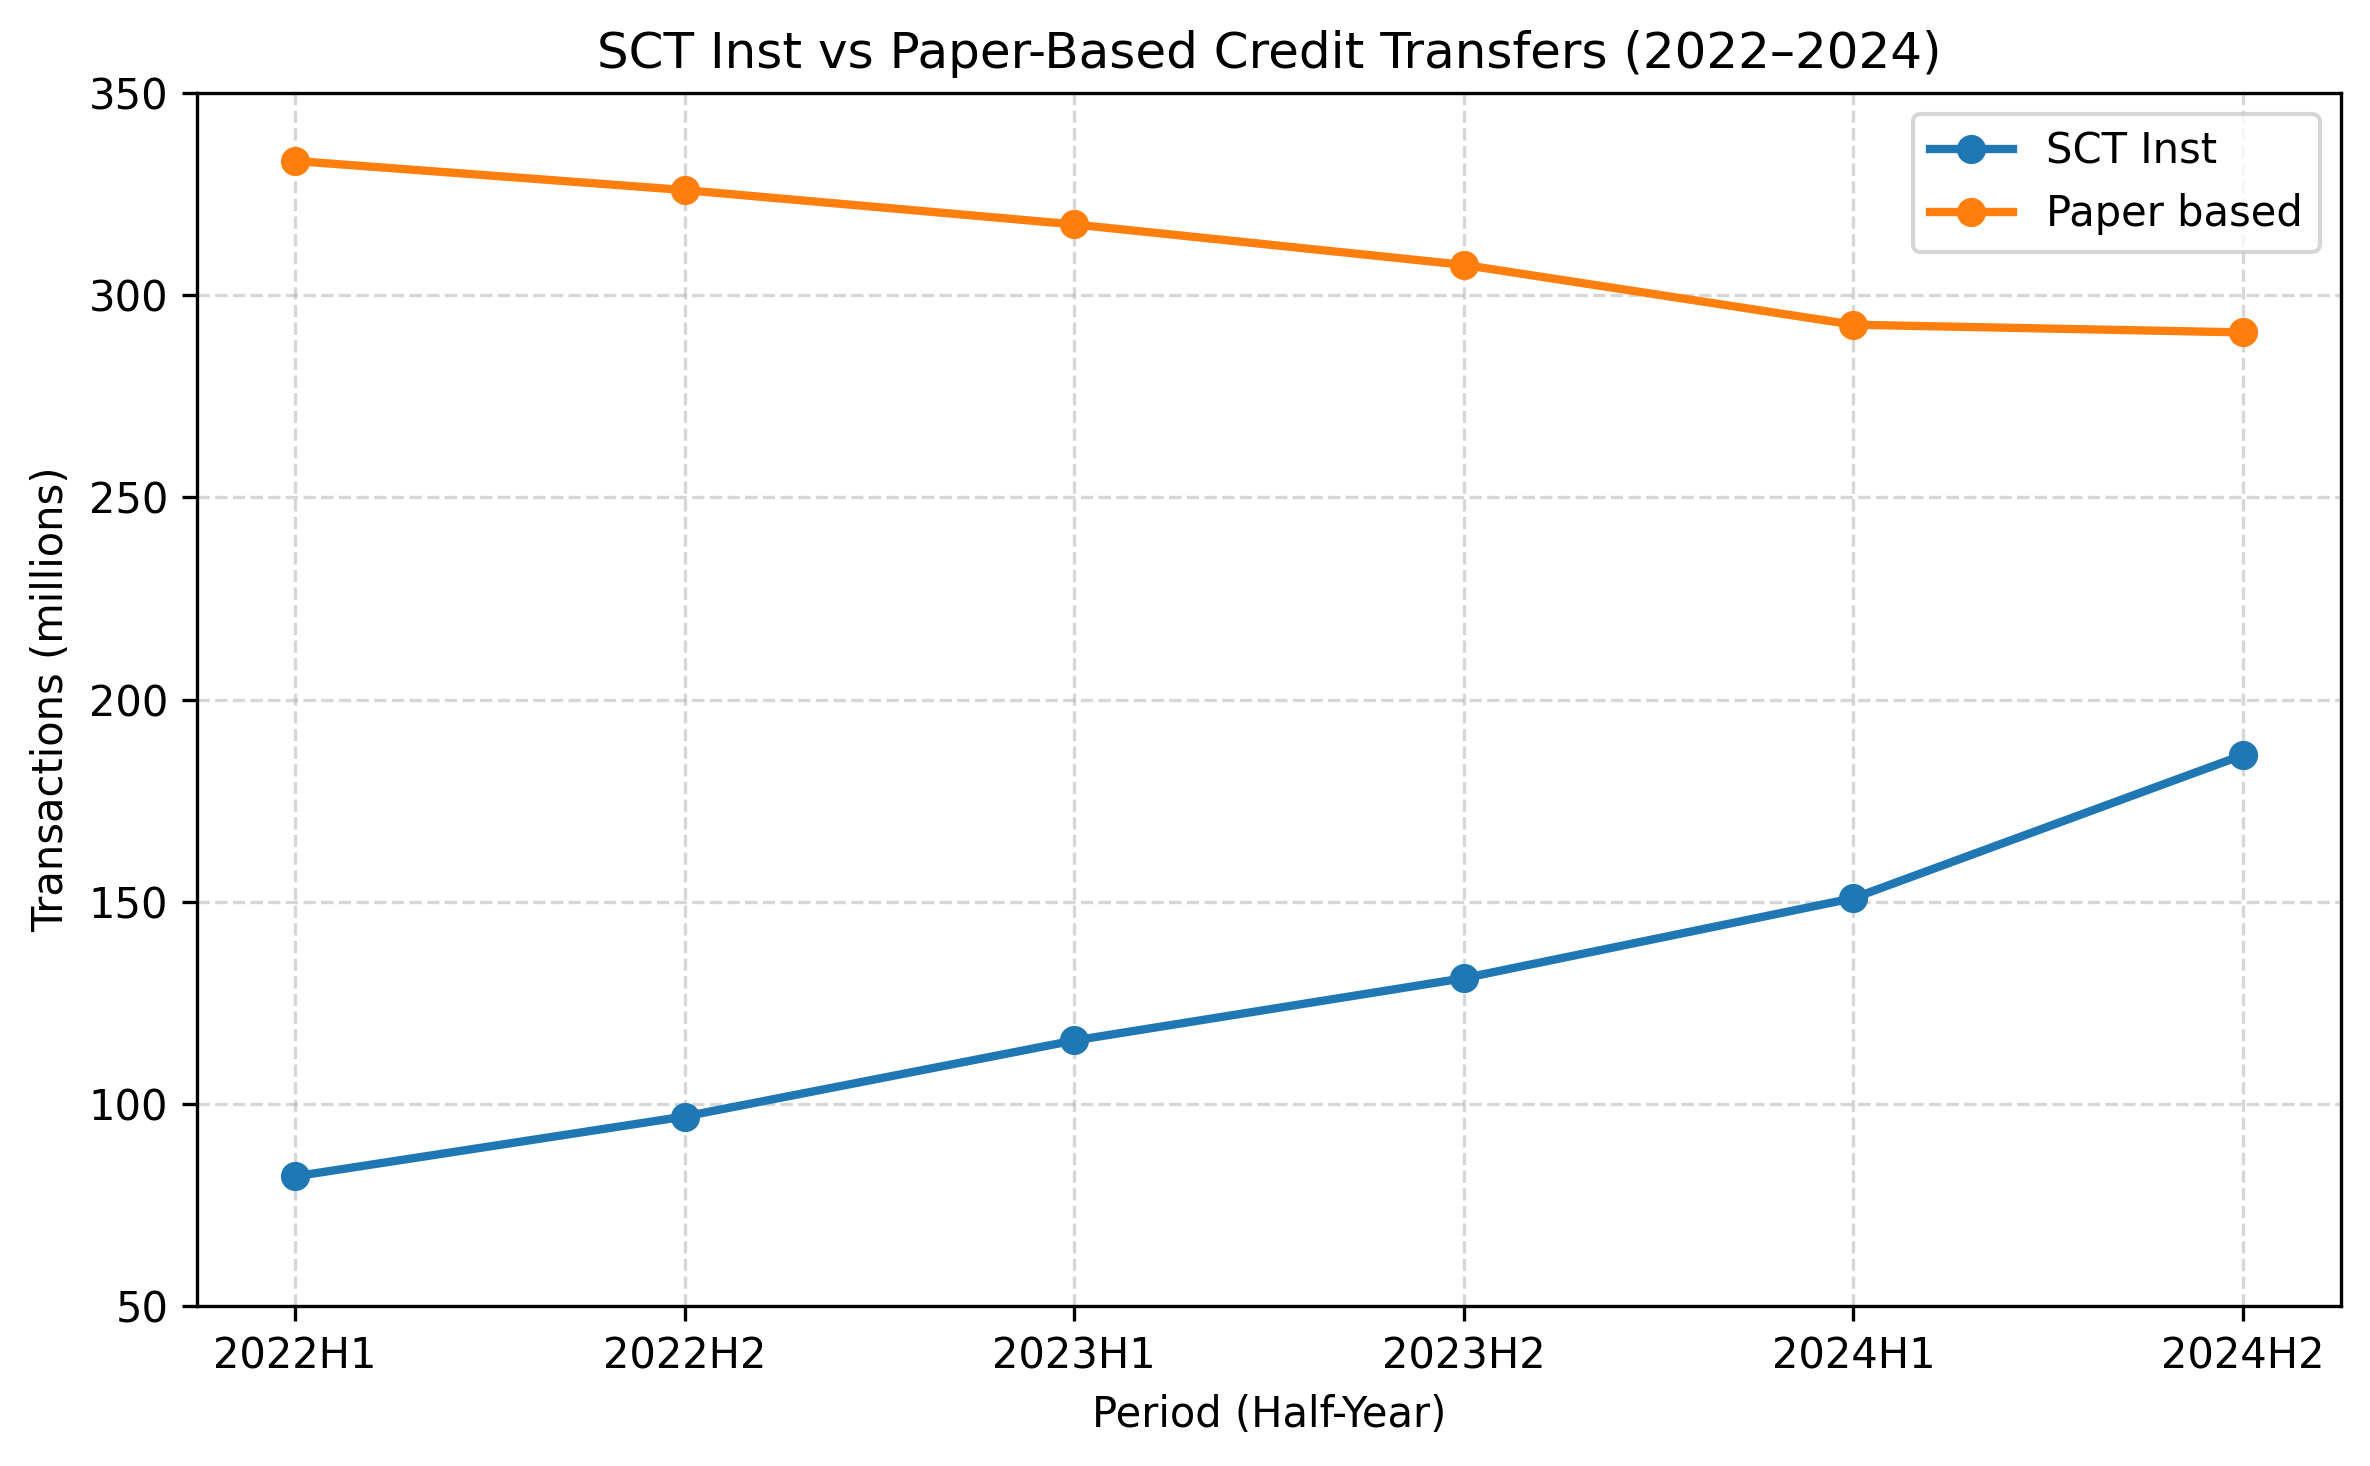

In [12]:
# H1 – stacked / line chart: SCT Inst vs Paper-based
show_fig("H1_stacked_sct_vs_paper.png")


### Interpretation (H1)

- **SCT Inst** volumes grow steadily from 2022H1 to 2024H2.  
- **Paper-based transfers** show a gradual decline over the same periods.

This supports **H1**:

> Instant and electronic credit transfers are **cannibalising paper-based transfers**,  
> confirming an ongoing **digital transformation** of the German payments market.

This is why an **Instant Payments Readiness Simulator** is relevant:  
banks must tune their fraud and VoP settings in a world where **instant, digital volumes keep growing**.


## H2 — Domestic Electronic Payments & System Load (Real Data)

**Question:**  
Does the total domestic volume of payment transactions (counts and values) show a clear upward trend,  
indicating growing **load on the payment infrastructure**?

**Data:**  
Bundesbank — same Table 3, but we filter:

- `Domestic` (for counts in millions)
- `Domestic` (for values in million EUR)

We aggregate by half-year and plot both **transaction counts** and **values** over time.


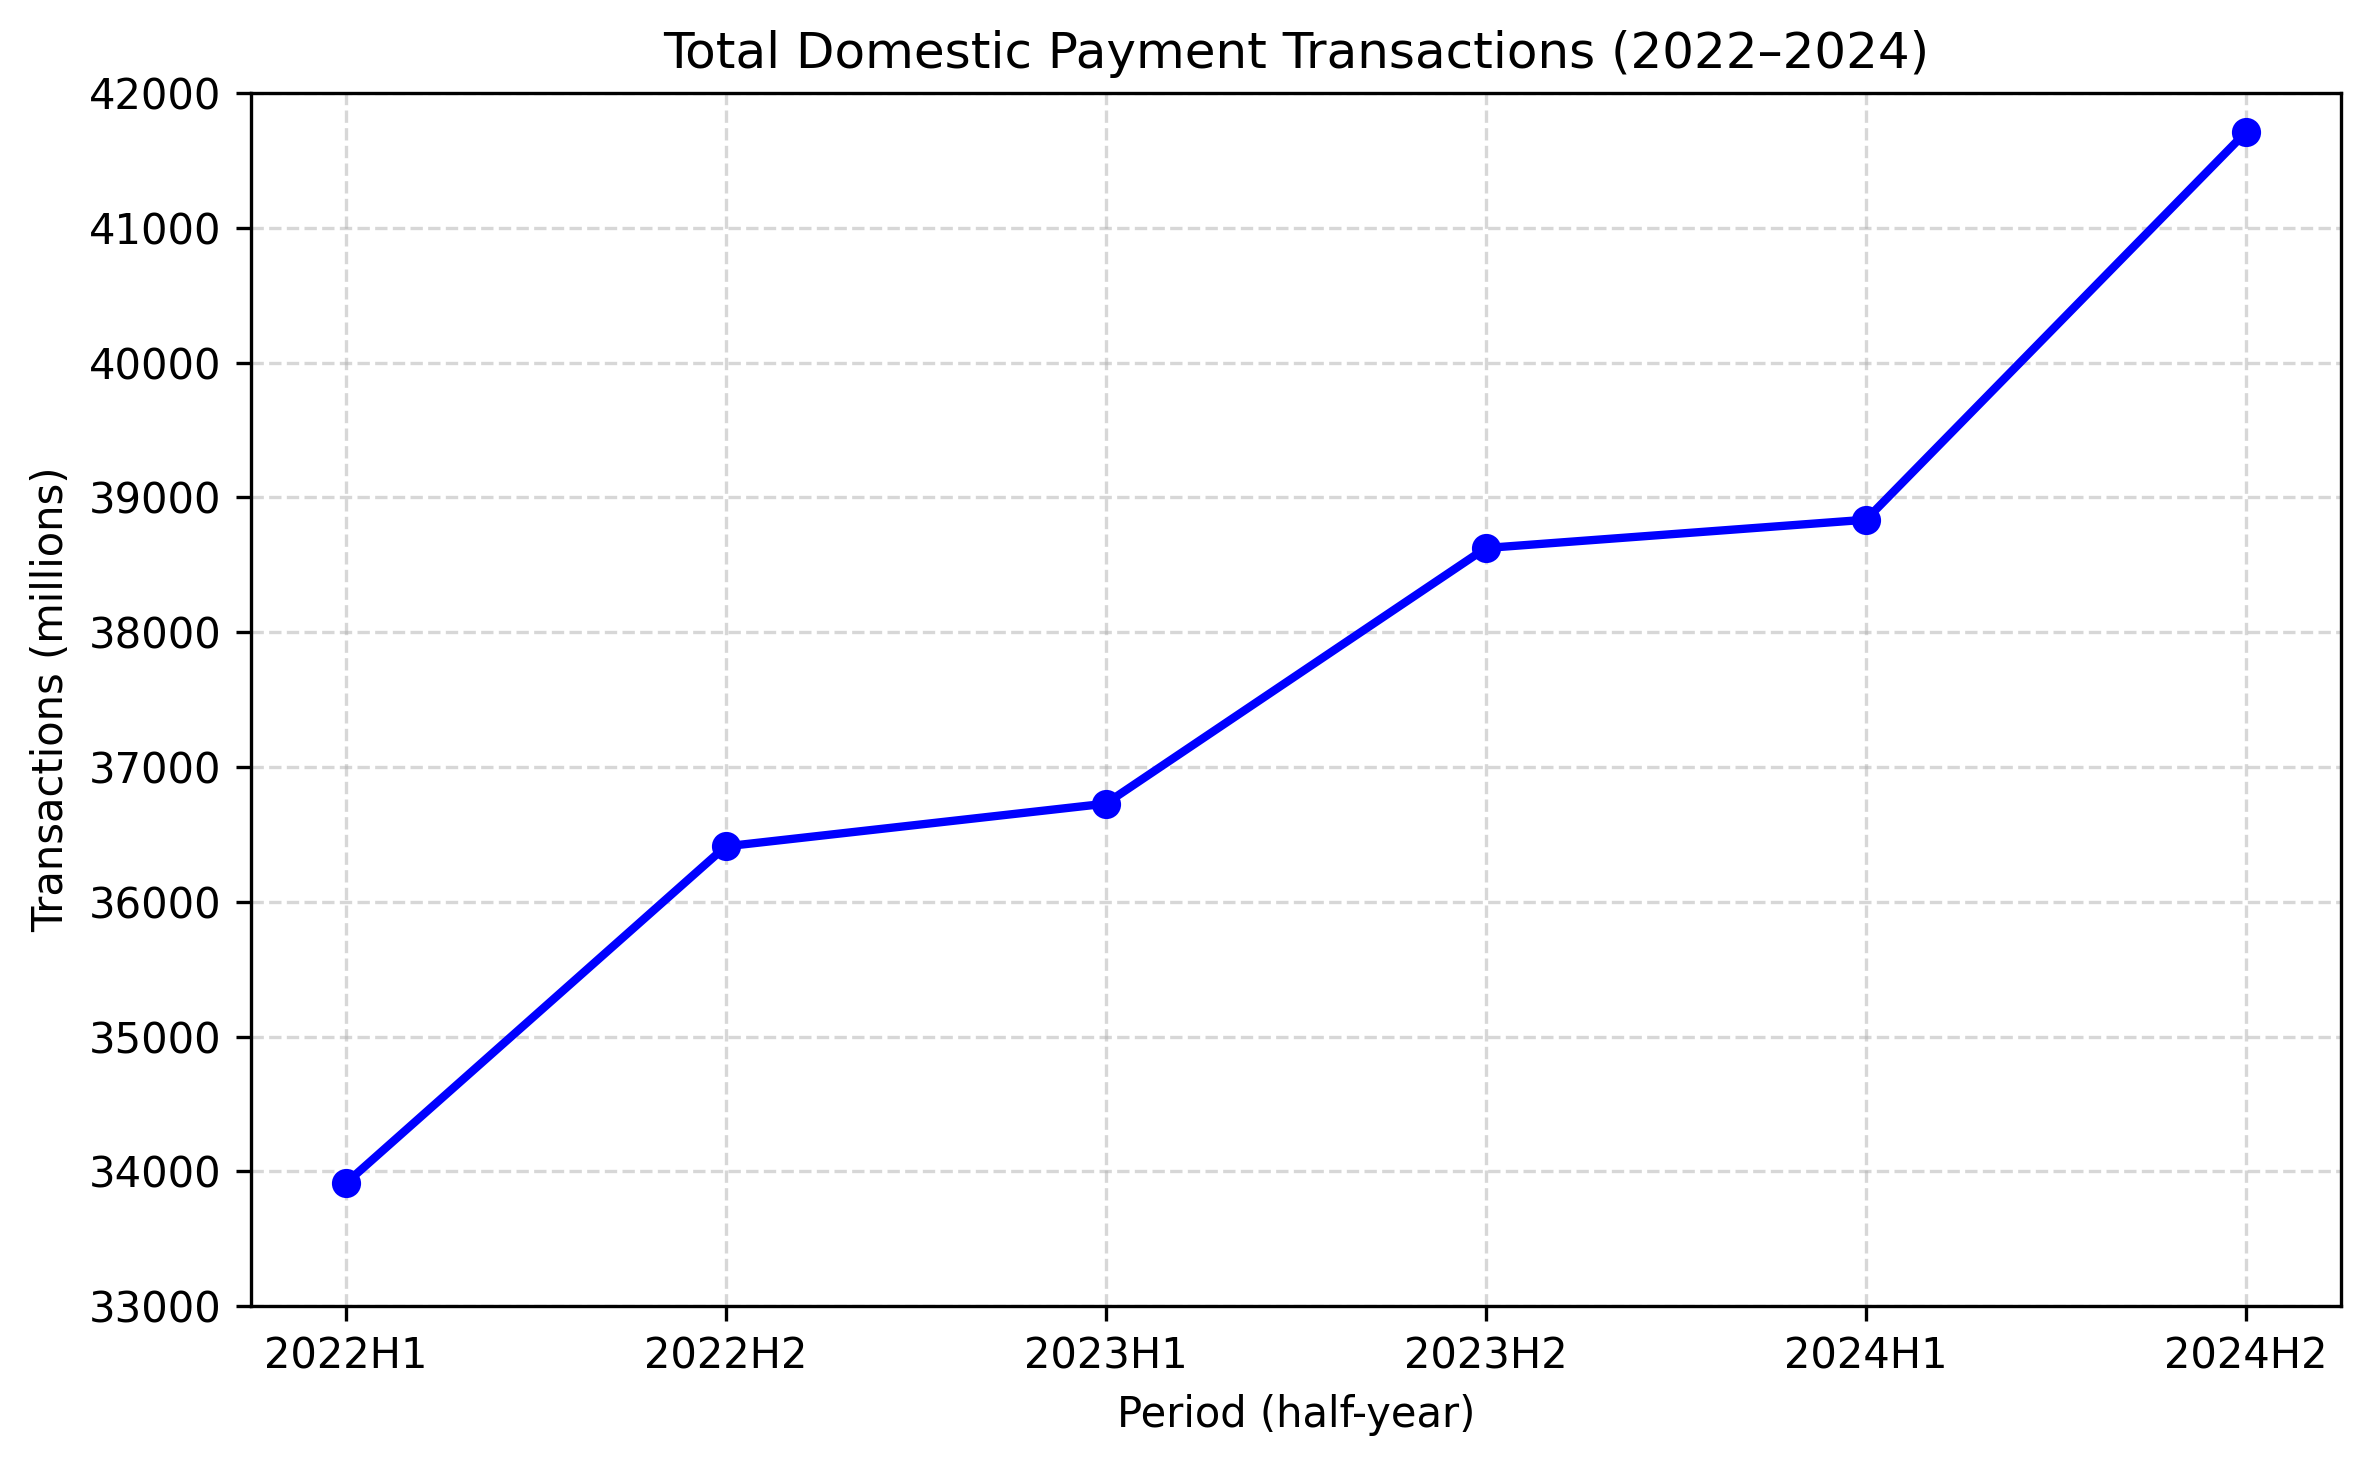

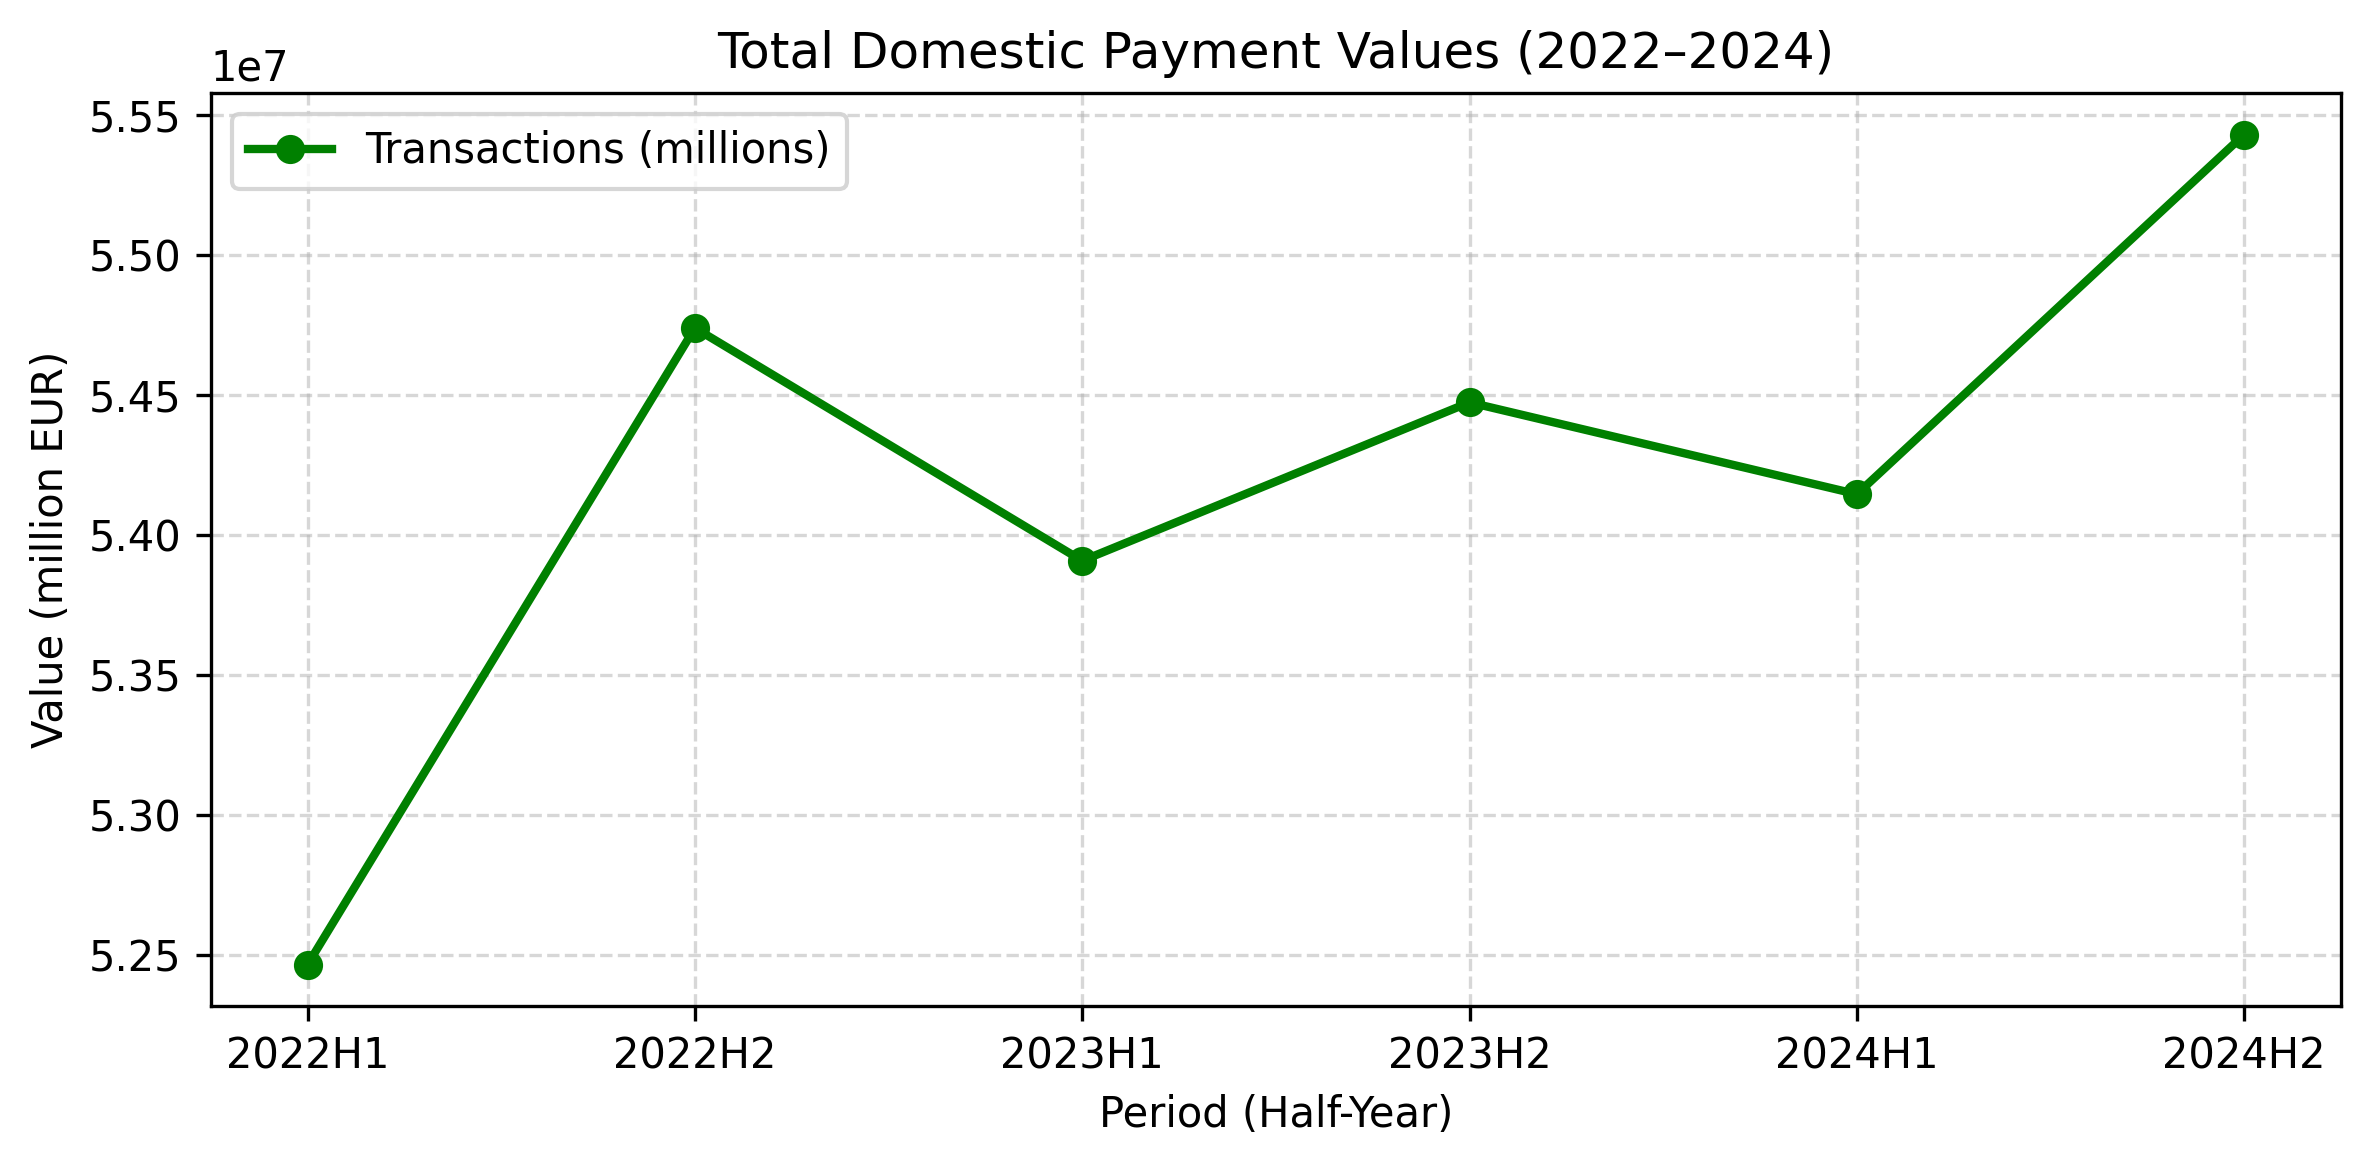

In [13]:
# Total domestic transactions (counts, millions)
show_fig("H2_total_domestic.png")

# Total domestic values (million EUR)
show_fig("H2_total_domestic_values.png")

### Interpretation (H2)

- **Domestic transaction counts** show a **clear upward trend** from 2022H1 to 2024H2.
- **Domestic transaction values (EUR)** also grow over time.

This confirms **H2**:

> The **underlying payment load** on banking infrastructure is increasing,  
> which makes monitoring **p95 latency** and operational bottlenecks critical.

These real trends provide **context** for the simulator:  
we calibrate synthetic volumes assuming that **instant payments will operate on top of an already growing baseline**.


## H3 — Fraud Threshold vs Manual Review Rate (Simulation)

**Question:**  
What happens to **manual review workload** when we change the fraud threshold?

**Setup (Synthetic):**

- We generate synthetic instant payments using `generate_synth()`:
  - `amount_eur` — transaction amount,
  - `fraud_probability` — model score between 0 and 1.
- We define a **fraud threshold**:
  - If `fraud_probability > threshold` → transaction is **flagged for manual review**.
- For each threshold we compute:
  - **Manual Review Rate (%)** — share of flagged transactions.

The plot below shows this relationship.


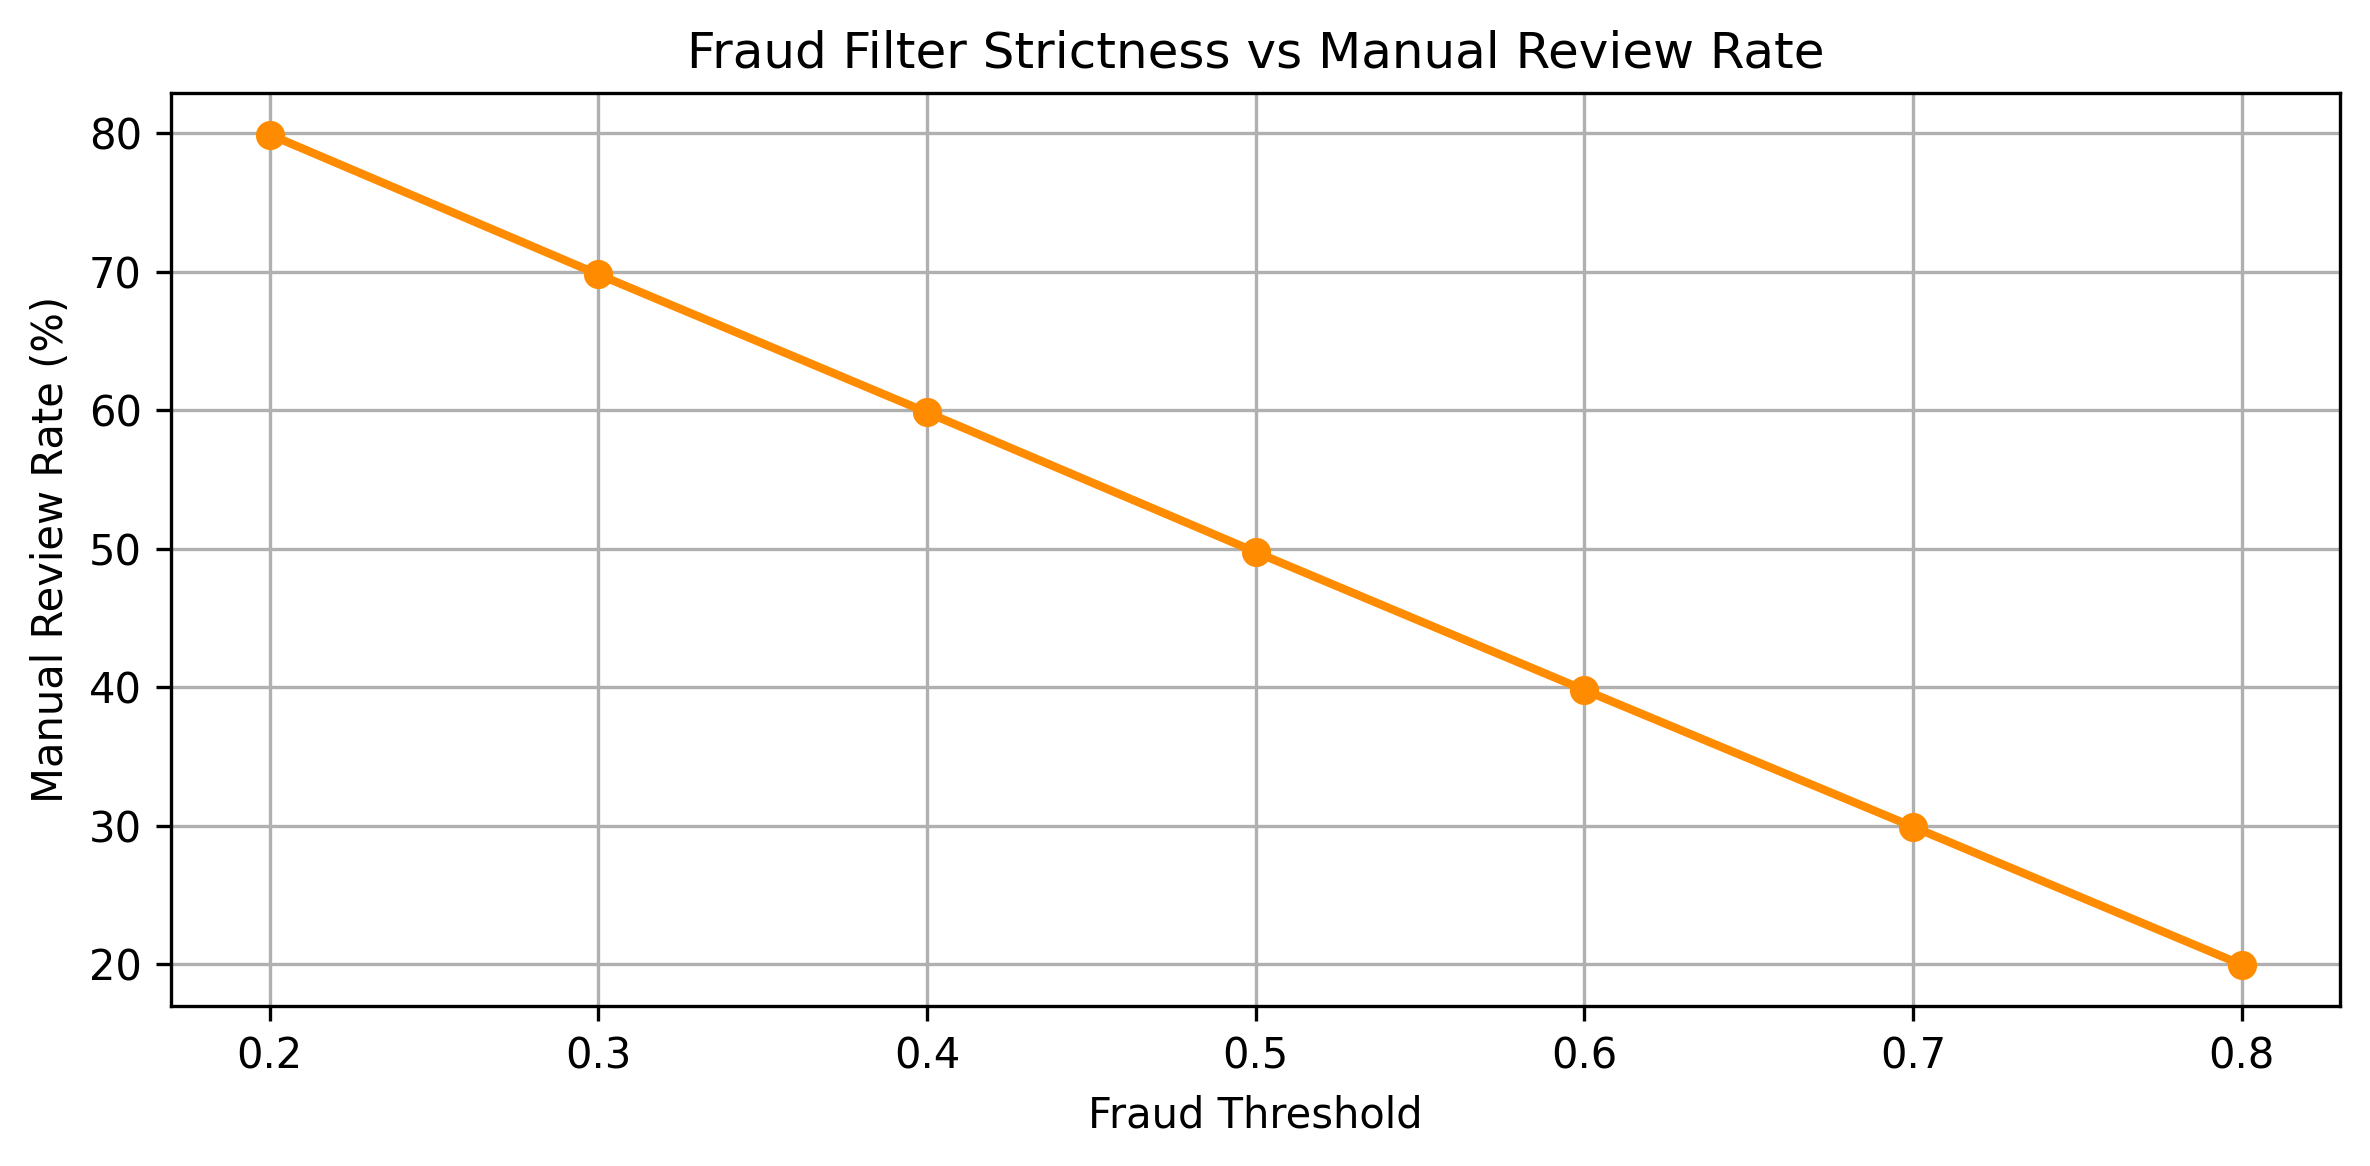

In [14]:
# H3 – fraud strictness vs manual review rate
show_fig("H3_line_fraud_manual_review.png")


### Interpretation (H3)

- When the **fraud threshold is low** (e.g. 0.2),  
  almost every slightly risky transaction is flagged → **high Manual Review Rate**.
- When the **fraud threshold is high** (e.g. 0.8),  
  far fewer transactions are flagged → **low Manual Review Rate**, but **more risk**.

This supports **H3**:

> Tight fraud filters **protect the bank** but **transfer load to human analysts**,  
> increasing operational cost and potentially slowing down the customer journey.


## H4 — Fraud Threshold vs Risk Exposure (Simulation)

**Question:**  
How does the **financial risk** change when we adjust the fraud threshold?

**Setup (Synthetic):**

- Using the same synthetic dataset,
- For each threshold we compute:
  - `risk_exposure_eur` — total amount (EUR) of transactions **not flagged** by the fraud filter  
    (proxy for *potentially missed fraud*).

The next chart shows how risk exposure grows when we relax fraud checks.


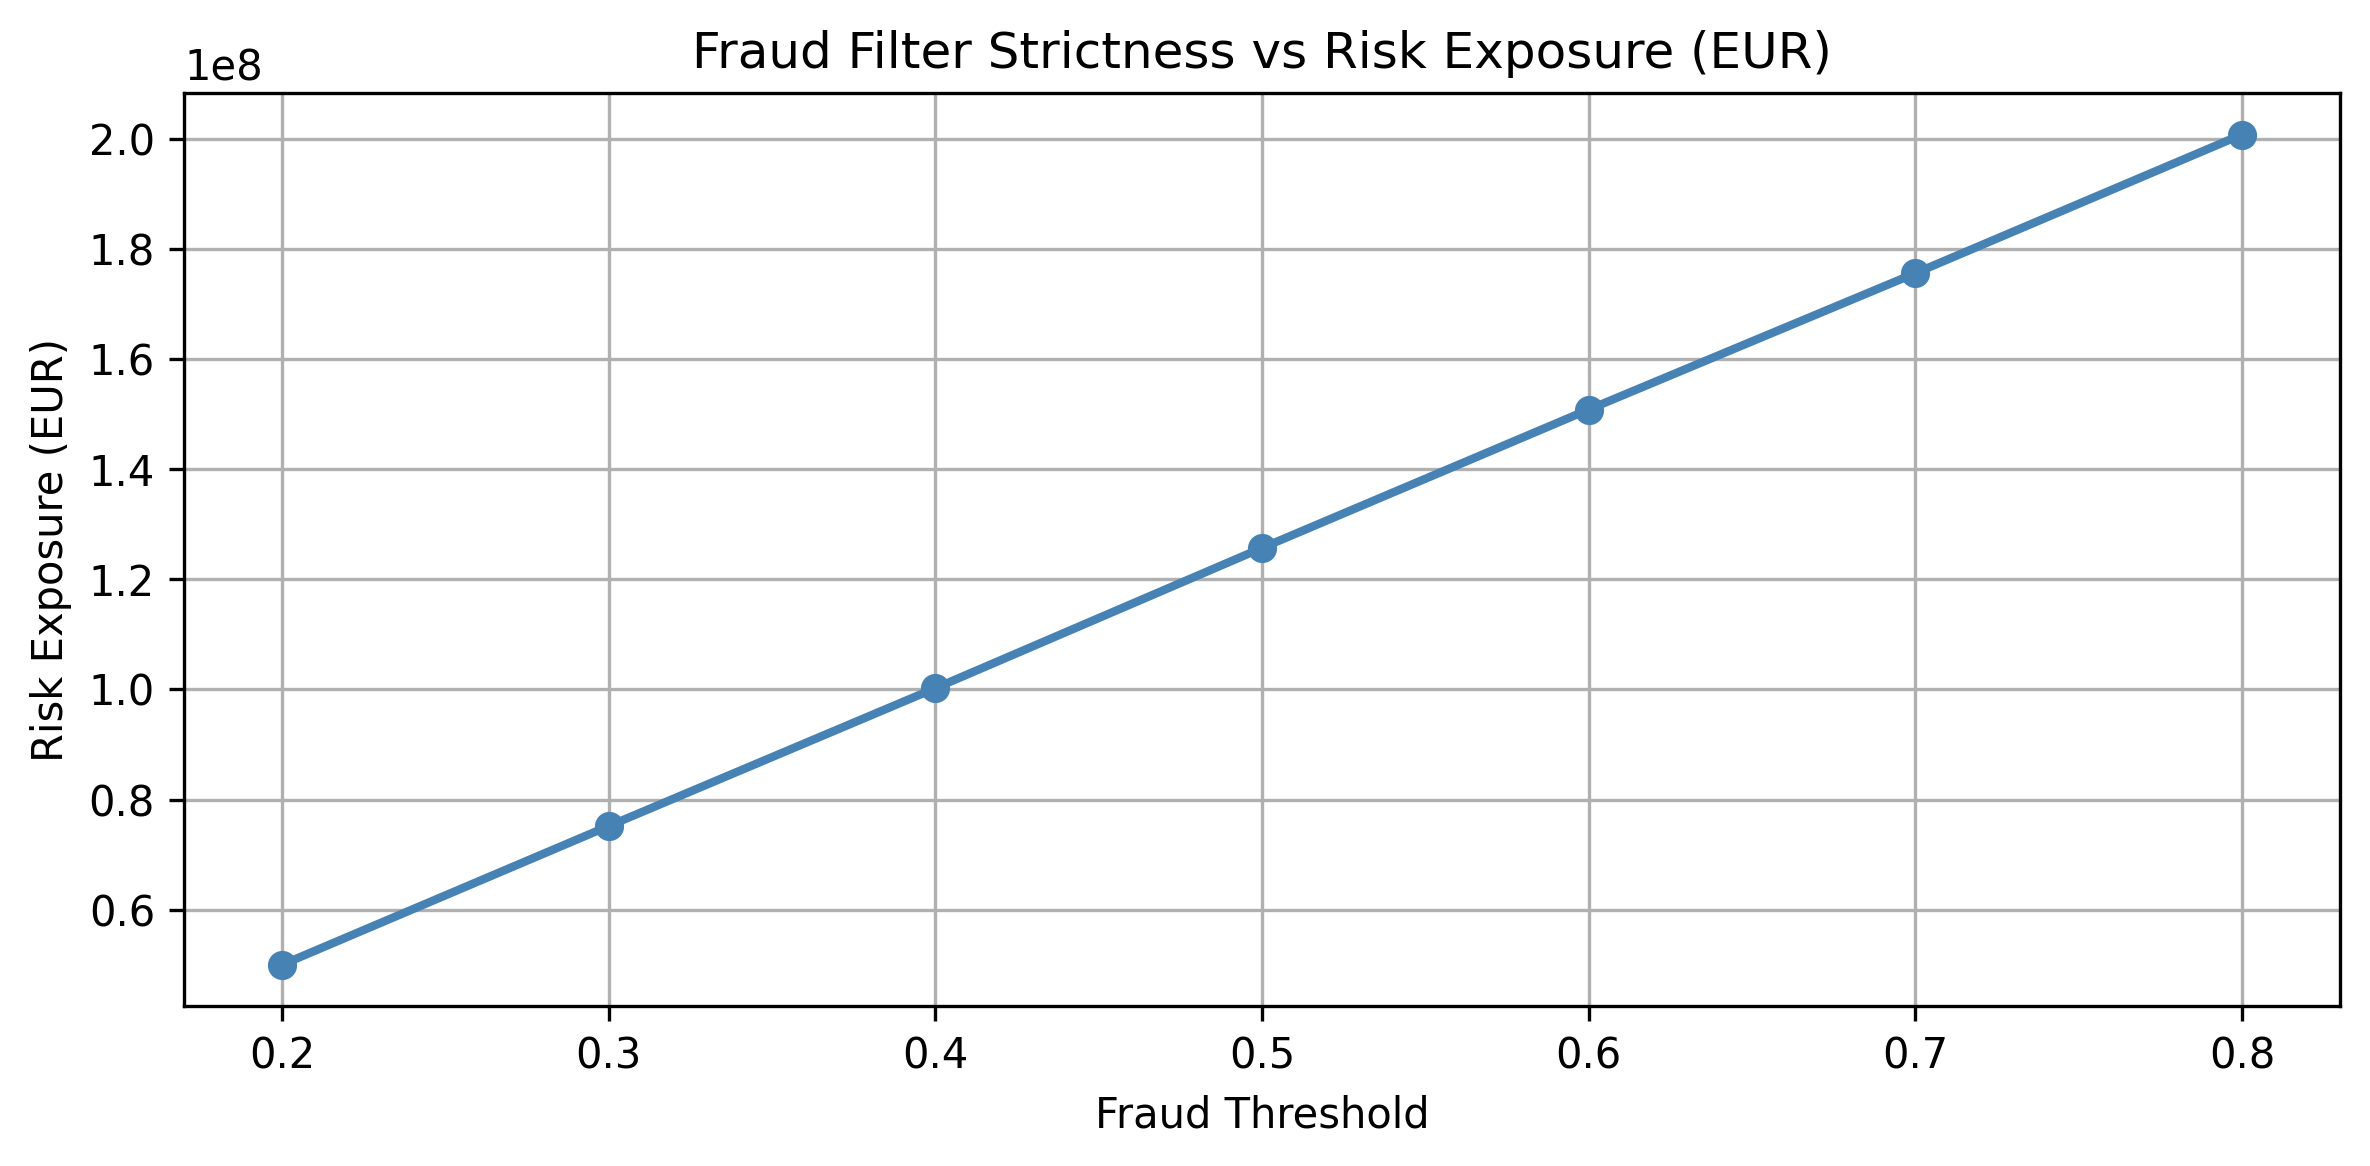

In [15]:
# H4 – fraud strictness vs risk exposure
show_fig("H4_line_fraud_risk_exposure.png")


### Interpretation (H4)

- At **low thresholds** the risk exposure is **low**,  
  because many suspicious payments are stopped or sent to manual review.
- As the **threshold increases**, more risky transactions slip through →  
  **Risk Exposure (EUR)** grows quickly.

This confirms **H4**:

> There is a **direct trade-off**:  
> lower thresholds → **less risk**, more manual reviews;  
> higher thresholds → **more risk**, fewer manual reviews.

In practice, the bank must find a **balance point**, where risk is acceptable and workload is manageable.


## H5 — Final KPI Heatmap: Optimal VoP × Fraud Balance

To summarise the simulator behaviour,  
we combine two dimensions:

- **VoP strictness** → affects *Conversion* and *Latency p95*.
- **Fraud strictness** → affects *Risk Exposure* and *Manual Review Rate*.

For each `(VoP threshold, Fraud threshold)` pair we compute a simple **KPI Score**  
that rewards high conversion and penalises high risk.  

The resulting heatmap highlights the **best operating zone**.


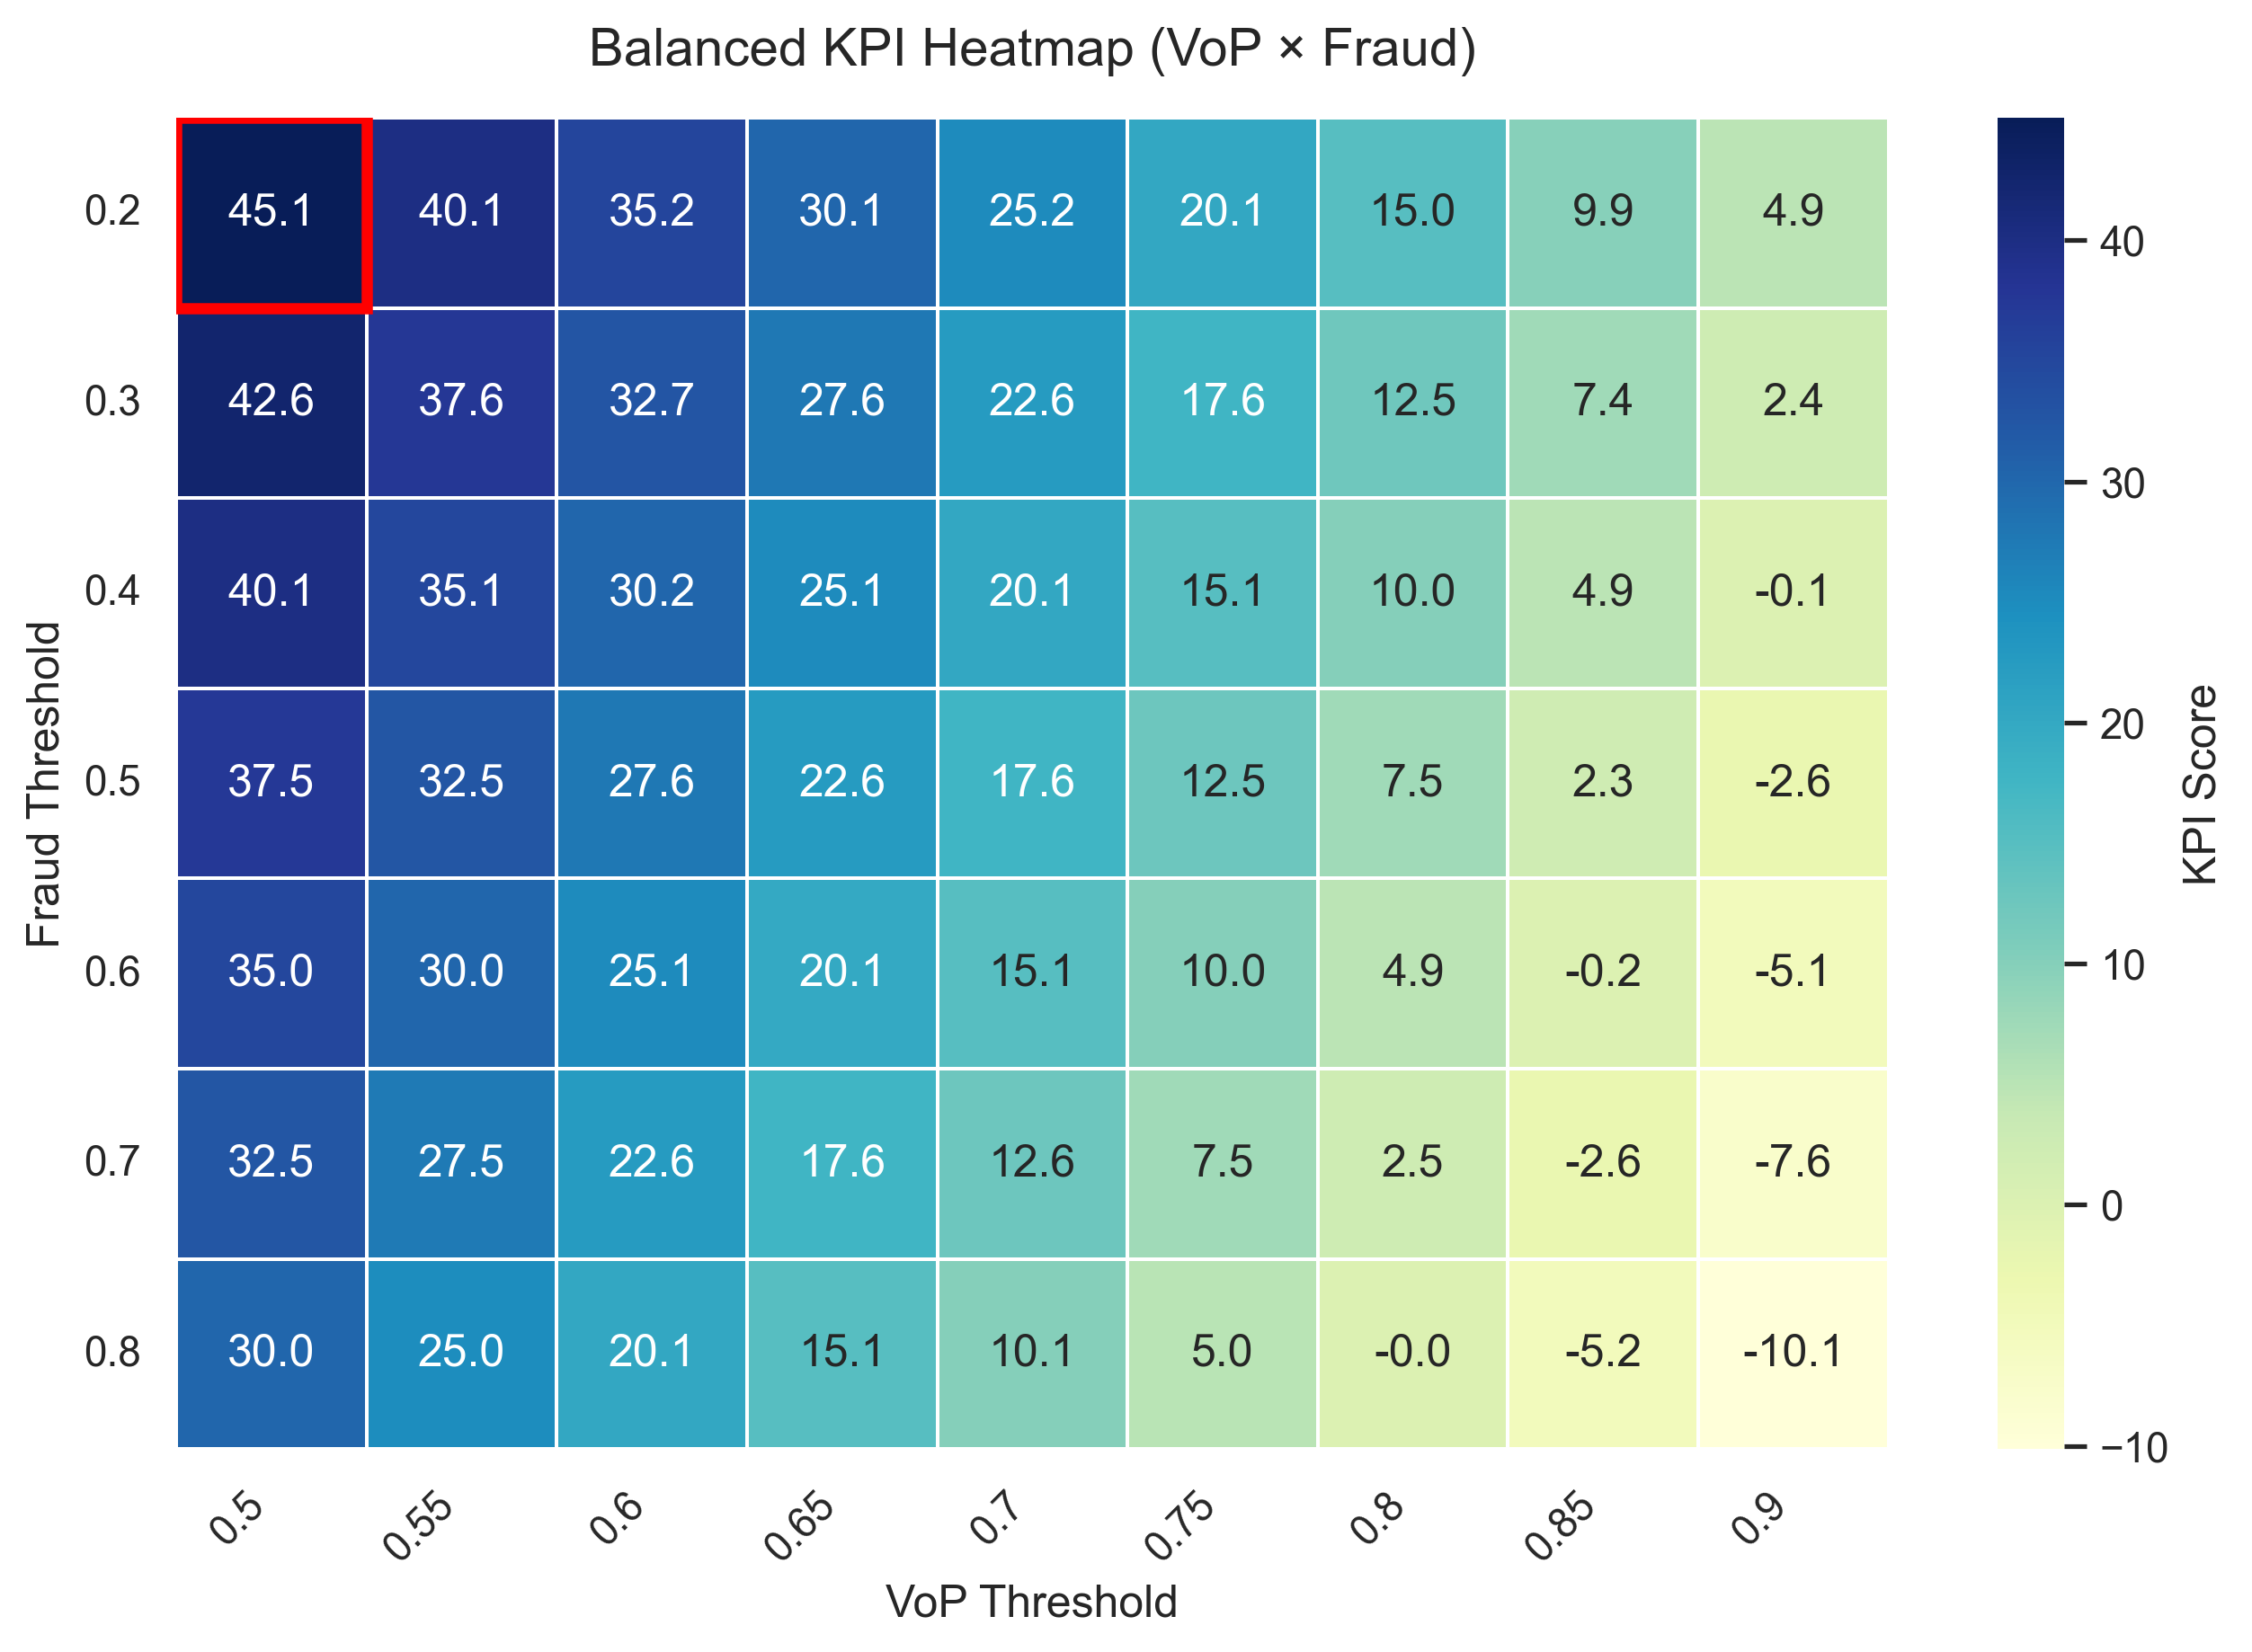

In [16]:
# H5 – combined VoP × Fraud heatmap (overall balance)
show_fig("H5_heatmap_vop_fraud_optimal.png")


### Interpretation (H5)

- Darker / higher cells correspond to a **better overall KPI balance**.
- The heatmap suggests that settings around:
  - **VoP ≈ 0.80**
  - **Fraud ≈ 0.50**
  give a **good compromise** between:
  - Conversion,
  - Latency p95,
  - Risk Exposure (EUR),
  - Manual Review Rate (%).

This provides a **practical recommendation**:

> Start with VoP around **0.8** and Fraud around **0.5**,  
> then fine-tune based on the bank’s actual risk appetite and staffing capacity.


## Overall Conclusions

1. **Market Trend (H1 & H2 — Real Data)**  
   - SCT Instant and electronic transfers are **steadily growing**,  
     while paper-based credit transfers decline.  
   - Total domestic payment volumes (both in **counts** and **values**) are rising,  
     signalling increasing **load on payment infrastructure**.

2. **Operational Trade-offs (H3 & H4 — Simulation)**  
   - **Stricter fraud thresholds** reduce financial risk but sharply increase  
     the **Manual Review Rate**, transferring workload to fraud operations teams.  
   - **Relaxed fraud thresholds** improve operational efficiency but  
     significantly increase **Risk Exposure (EUR)**.

3. **Optimal Operating Zone (H5 — Heatmap)**  
   - By scanning VoP and Fraud thresholds together,  
     we identify an **operating “sweet spot”** around VoP ≈ 0.8 and Fraud ≈ 0.5.  
   - This zone keeps **conversion healthy**, **latency reasonable**,  
     and **risk under control**, without overwhelming manual review capacity.

Overall, the project connects **real payment statistics** with a **practical instant payments simulator**,  
showing how data can support decisions on **VoP, fraud filters, and infrastructure readiness** in a German bank.
